# 2016 US Bike Share Activity Analysis

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

This project performs an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. The system usage is compared between three large cities: New York City, Chicago, and Washington, DC. Several differences within each system are identified for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

**Questions**:  
            What kind of users actually use bike sharing?  
            How often does the average customer use bike sharing?  
            How should the pricing be to make money?    

<a id='wrangling'></a>
## Data Collection and Wrangling

This project focuses on the record of individual trips taken in 2016 from the selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page, where the trip data can be freely downloaded:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

Each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly.  

Each of the cities are investigated. Firstly the first trip recorded from each of the cities is printed out.

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## Uses the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        
        ## Uses a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        
        ## Uses the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        pprint(first_trip)
        
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
#data_files = ['./examples/BayArea-Y3-Summary.csv']
data_files = ['./data/NYC-CitiBike-2016.csv',
               './data/Chicago-Divvy-2016.csv',
               './data/Washington-CapitalBikeshare-2016.csv']

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

Below the printout of each city name (which has been parsed from the data file name) the first trip has been parsed in the form of a dictionary. When setting up the `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This is useful since I will refer to quantities by an easily-understandable label instead of just a numeric index. For example, for a trip stored in the variable `row`, then you would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible for the actual exploration, the data will trimmed and cleaned. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data that are most interesting whick makes the exploration easier to work with.

New data files are generated with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Start time of the trip is used to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, these are converted to the Washington labels to match the other two.
  
  
Next some helper functions are created to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    #Computing the duration time in mins
    if (city == 'NYC' or city == 'Chicago'):
        duration = float(datum['tripduration'])/60
    else:
        duration = float(datum['Duration (ms)'])/60/1000
    return duration


# Some tests to check that the code works. There should be no output if all of
# the assertions pass. 
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    NYC includes seconds, while Washington and Chicago do not.
    """
    #strptime reads the date in the defined format from the string. Then strftime defines the output format
    if city == 'Chicago':
        hour = int(datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M").strftime("%H"))
        month = int(datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M").strftime("%m"))
        day_of_week = datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M").strftime("%A")
    elif city == 'Washington':
        hour = int(datetime.strptime(datum['Start date'],"%m/%d/%Y %H:%M").strftime("%H"))
        month = int(datetime.strptime(datum['Start date'],"%m/%d/%Y %H:%M").strftime("%m"))
        day_of_week = datetime.strptime(datum['Start date'],"%m/%d/%Y %H:%M").strftime("%A")
    elif city == 'NYC':
        hour = int(datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M:%S").strftime("%H"))
        month = int(datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M:%S").strftime("%m"))
        day_of_week = datetime.strptime(datum['starttime'],"%m/%d/%Y %H:%M:%S").strftime("%A")
    
    return (month, hour, day_of_week)


# Some tests to check that the code works. There should be no output if all of
# the assertions pass. 
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    time_of_trip(example_trips[city], city)
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Washington has different category names compared to Chicago
    and NYC. 
    """
    #Reading user types
    if (city == 'NYC' or city == 'Chicago'):
        user_type = str(datum['usertype'])
    elif city == 'Washington':
        user_type = str(datum['Member Type'])
            
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. 
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Registered'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

A condensed data file for each city are created using the helper functions above. 

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## uses the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            new_point['duration'] = duration_in_mins(row, city)
            new_point['month'], new_point['hour'], new_point['day_of_week'] = time_of_trip(row, city)
            new_point['user_type'] = type_of_user(row, city)

            trip_writer.writerow(new_point)            

In [7]:
# Checking the work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666667'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Registered')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now the data is collected and wrangled, the exploring will start. In this section I will compute descriptive statistics from the data and create visualizations using matplotlib.

<a id='statistics'></a>
### Statistics

First some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. 

**Questions to answer**:  
- Which city has the highest number of trips?   
- Which city has the highest proportion of trips made by subscribers?   
- Which city has the highest proportion of trips made by short-term customers?  

**Answer**:  
This is the data I compiled from the data sets for the different towns:
  
City (subscribers, short term customers, total rides, % subscriber rides, % short term rides)  
Washington (51753, 14573, 66326, 78, 21)  
Chicago (54982, 17149, 72131, 76, 23)  
NYC (245896, 30902, 276798, 88, 11)  

NYC has the highest amount of subscriber rides and approximately 4 times as many total rides as the second largest, which is Chicago.
88% of the rides in NYC is subscribers which also positions NYC as the town with the highest percentage of registered riders. Washington and Chicago is close to the same level with respectively 78% and 76% of rides being carried out by registered customers. In Chicago 23% of all trips are carried out by short-term customers.

In [8]:
def number_of_trips(filename, city):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        time_subscribers = 0
        time_customers = 0
        
        # tally up ride types depending on city
        for row in reader:
            if (city == 'NYC' or city == 'Chicago' or city == 'Bay Area'):
                if row['user_type'] == 'Subscriber':
                    n_subscribers += 1
                    time_subscribers += float(row['duration'])
                else:
                    n_customers += 1
                    time_customers += float(row['duration'])
            elif city == 'Washington':
                if row['user_type'] == 'Registered':
                    n_subscribers += 1
                    time_subscribers += float(row['duration'])
                else:
                    n_customers += 1
                    time_customers += float(row['duration'])
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # Compute percentages of rides
        per_subscribers = n_subscribers/n_total*100
        per_short_term = n_customers/n_total*100
        
        #Compute avg. time for subscribers and customers
        avg_customers = time_customers / n_customers
        avg_subscribers = time_subscribers / n_subscribers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total, int(per_subscribers),int(per_short_term), round(avg_customers,2),round(avg_subscribers,2))

In [9]:
city_info = {'Bay Area': './examples/BayArea-Y3-Summary.csv',
             'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC':'./data/NYC-2016-Summary.csv'}

print('City','(subscribers,','short term customers,','total rides,','% subscriber rides,','% short term rides,','avg min customers,','avg min subscribers)')
for city in city_info:
        print(city, number_of_trips(city_info[city], city))

City (subscribers, short term customers, total rides, % subscriber rides, % short term rides, avg min customers, avg min subscribers)
Bay Area (5666, 633, 6299, 89, 10, 54.55, 9.51)
Washington (51753, 14573, 66326, 78, 21, 41.68, 12.53)
Chicago (54982, 17149, 72131, 76, 23, 30.98, 12.07)
NYC (245896, 30902, 276798, 88, 11, 32.78, 13.68)


**Question**:  
Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?
  
**Answer**:  
This is the data from the function below:  

City  (average time, % above 30min)  
Bay Area Test (14.04, 3.52)  
Washington (18.93, 10.84)  
Chicago (16.56, 8.33)  
NYC (15.81, 7.3)  

The same data was found in the Bay Area as described in the exercise.
The average time in all cities are below 30min as expected from the description above. However, rides over 30 minutes happens as well. Washington was found to have the highest amount of rides above 30 min with 10.84% of all rides taking more than 30 minutes.

In [10]:
def bike_ride_avg(filename):
    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
    
        #Initiate counters
        rides = 0
        rides_over_30 = 0
        total_time = 0
        
        # read ride time and register ride times above 30min
        for row in reader:
            time = float(row['duration'])
            rides += 1
            total_time += time
            if time > 30:
                rides_over_30 += 1
            
        avg_time = total_time / rides 
        per_over_30 = rides_over_30 / rides * 100
    return round(avg_time,2), round(per_over_30,2)        
        
city_info = {'Bay Area Test': './examples/BayArea-Y3-Summary.csv',
             'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC':'./data/NYC-2016-Summary.csv'}

print('City',' (average time,','% above 30min)')
for city in city_info:
    print(city, bike_ride_avg(city_info[city]))

City  (average time, % above 30min)
Bay Area Test (14.04, 3.52)
Washington (18.93, 10.84)
Chicago (16.56, 8.33)
NYC (15.81, 7.3)


**Question**:  
Dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?  
  
**Answer**:   
This table is generated:  
City avg customers[min], avg subscribers[min]  
Bay Area 54.55 9.51  
Washington 41.68 12.53  
Chicago 30.98 12.07  
NYC 32.78 13.68  
  
In general for all cities customers takes longer journeys. Looking away from the Bay Area, then Washington is the city with the biggest difference between customers and subscribers.

In [11]:
city_info = {'Bay Area': './examples/BayArea-Y3-Summary.csv',
             'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC':'./data/NYC-2016-Summary.csv'}

print('City','avg customers[min],','avg subscribers[min]')
for city in city_info:
        print(city, number_of_trips(city_info[city], city)[5], number_of_trips(city_info[city], city)[6])

City avg customers[min], avg subscribers[min]
Bay Area 54.55 9.51
Washington 41.68 12.53
Chicago 30.98 12.07
NYC 32.78 13.68


<a id='visualizations'></a>
### Visualizations

The last set of computed values pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting to look at how the trip times are distributed. 

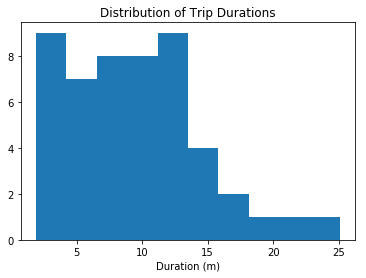

In [12]:
# load library
import matplotlib.pyplot as plt
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

In the above cell, fifty trip times are collected in a list, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.
  
These functions will be used to create a histogram of the trip times for Washington. 

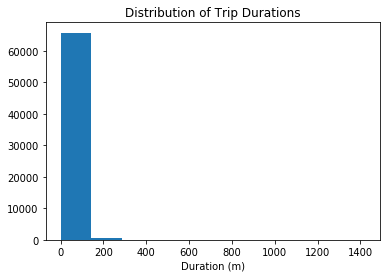

In [13]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##
# load library
import matplotlib.pyplot as plt
%matplotlib inline 

#reading histogram data from Washington
data = []
filename ='./data/Washington-2016-Summary.csv'
f_in = open(filename,'r')
reader = csv.DictReader(f_in)
for row in reader:
    data.append(float(row['duration']))
    
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()


This plot suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, some additional parameters will be used with the `.hist()` function to limit the range of data that is plotted. Documentation for the function can be found [[here]](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist).

**Question**:  
Use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in Washington. Do the same thing for only the Customers. Add limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, set the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?
   
**Answer**:  
Customers:  
The histogram is unimodal when plotting the duration for customers with a peak at 15-20min and the major part of trips takes between 5-35min. The plot shows a long tail, which means a lof of customers also take quite long rides. 
The histogram shows some non-symmetric bimodal tendencies, as the duration has a small increase again at 55-60min.
  
Subscribers:  
The histogram is unimodal when plotting the duration for subscribers with a peak at 5-10min and the major part of trips takes between 0-20min. After 20min the graph seems to flatten out much faster than for the customers.  
  
Overall, it seems that customers have a bigger variety in the duration but another part to take into account is the big difference in trips. Approximately 2000 customers have taken a ride between 15-20min whereas approximately 17500 subscribers have taken a ride between 5-10min. It seems that the customers have a larger spread in the data.

In fact, the subscribers also take long rides but compared to the big amount of short rides you can barely see it on the plot.
Both histogram's shows a positive skew as the right tail is longer and the mass of the distribution is concentrated on the left side of the histogram. 

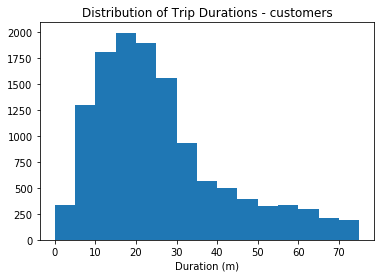

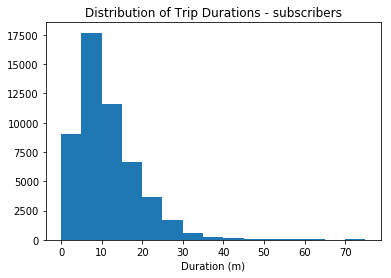

In [14]:
# load library
import matplotlib.pyplot as plt
%matplotlib inline 

#reading histogram data from Washington
filename ='./data/Washington-2016-Summary.csv'
f_in = open(filename,'r')
reader = csv.DictReader(f_in)
#Splitting durations into subscribers and customers
data_subs = []
data_cust = []
for row in reader:
    if row['user_type'] == 'Registered':
        data_subs.append(float(row['duration']))
    else:
        data_cust.append(float(row['duration']))

#Plotting customers
plt.hist(data_cust,range=(0,75), bins = 15)
plt.title('Distribution of Trip Durations - customers')
plt.xlabel('Duration (m)')
plt.show()

#Plotting subscribers
plt.hist(data_subs,range=(0,75), bins = 15)
plt.title('Distribution of Trip Durations - subscribers')
plt.xlabel('Duration (m)')
plt.show()

<a id='eda_continued'></a>
## Further Analysis

So far an initial exploration into the data available has been conducted. I have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For Washington, I have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Here are some new questions to explore:  
  
- How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?
- Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?
- During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?

**Question**:  
Continue the investigation by exploring another question that could be answered by the data available. Document the question to be explored below. The investigation should involve at least two variables and should compare at least two groups. Also include at least one visualization as part of the explorations.  
  
**Answer**:   
I have investigated the following:  
Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?  
  
For all 3 cities there are plots further below showing the average amount of rides on a weekday compared to a day in the weekend. Generally for all cities, there is a larger amount of rides on an average weekday than a day in the weekend.

**Washington**  
For Washington the day of most subscriber rides is: Wednesday  
For Washington the day of most customer rides is: Monday   
  
Table of average riding time  
Mon Tue Wed Thu Fri Sat Sun  
17.56, 16.69, 16.29, 16.69, 17.93, 24.81, 23.97 [min]  
For Washington the day with longest rides is Saturday and the day with the shortest rides is Wednesday  
  
**Chicago**  
For Chicago the day of most subscriber rides is: Tuesday  
For Chicago the day of most customer rides is: Sunday  
  
Table of average riding time  
Mon Tue Wed Thu Fri Sat Sun  
16.12, 14.3, 14.46, 13.93, 15.58, 20.63, 21.38 [min]  
For Chicago the day with longest rides is Sunday and the day with the shortest rides is Thursday  
  
**NYC**  
For NYC the day of most subscriber rides is: Wednesday  
For NYC the day of most customer rides is: Saturday  
  
Table of average riding time  
Mon Tue Wed Thu Fri Sat Sun  
15.08, 14.3, 14.64, 14.55, 16.02, 18.8, 18.79 [min]  
For NYC the day with longest rides is Saturday and the day with the shortest rides is Tuesday  

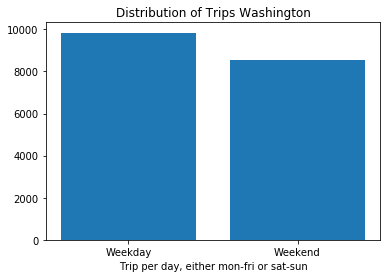

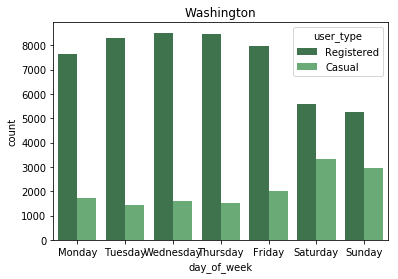

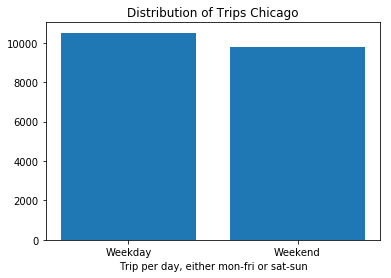

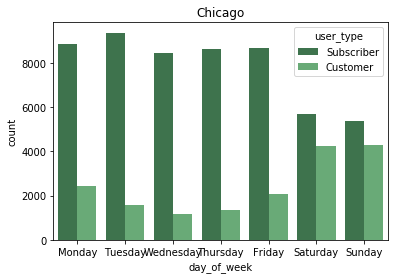

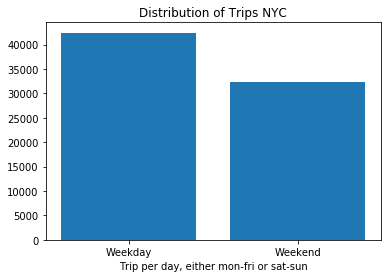

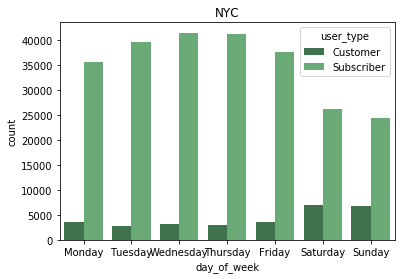

In [15]:
import plotly.plotly as py

def count_week_days(list):
    mon, tue, wed, thu, fri, sat, sun = 0,0,0,0,0,0,0
    for row in list:
        if row == 'Monday':
            mon += 1
        elif row == 'Tuesday':
            tue += 1
        elif row == 'Wednesday':
            wed += 1
        elif row == 'Thursday':
            thu += 1
        elif row == 'Friday':
            fri += 1
        elif row == 'Saturday':
            sat += 1
        elif row == 'Sunday':
            sun += 1

    return (mon,tue,wed,thu,fri,sat,sun)

def plot_week_vs_end(filename, city):
    #reading specified filename
    f_in = open(filename,'r')
    reader = csv.DictReader(f_in)
    
    #Reading weekday or weekend
    count_week = 0
    count_day = 0
    for row in reader:
        if (row['day_of_week'] == 'Monday' or row['day_of_week'] == 'Tuesday' or 
            row['day_of_week'] == 'Wednesday' or row['day_of_week'] == 'Thursday' 
            or row['day_of_week'] == 'Friday'):
            count_day += 1
        elif (row['day_of_week'] == 'Saturday' or row['day_of_week'] == 'Sunday'):
            count_week += 1
    # Plotting weekday numbers vs weekend numbers
    x = ['Weekday','Weekend']
    y = [count_day/5, count_week/2]
    plt.bar(x,y)
    plt.xlabel('Trip per day, either mon-fri or sat-sun')
    plt.title('Distribution of Trips {0}'.format(city))
    plt.show()

def sub_days(filename, city):
    #reading specified filename    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        days = []
        
        # Finding max ridership day for subscribers
        for row in reader:
            if (city == 'NYC' or city == 'Chicago' or city == 'Bay Area'):
                if row['user_type'] == 'Subscriber':
                    days.append(row['day_of_week'])
            elif city == 'Washington':
                if row['user_type'] == 'Registered':
                    days.append(row['day_of_week'])
    days_count = count_week_days(days)
    maxPos = days_count.index(max(days_count))
    dateArray = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    return print('For', city,'the day of most subscriber rides is:', dateArray[maxPos])

def cust_days(filename, city):
    #reading specified filename    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        days = []
        
        # Finding max ridership day for subscribers
        for row in reader:
            if row['user_type'] == 'Customer':
                    days.append(row['day_of_week'])
    days_count = count_week_days(days)
    maxPos = days_count.index(max(days_count))
    dateArray = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    return print('For', city,'the day of most customer rides is:', dateArray[maxPos])

def ride_time_days(filename,city):
     #reading specified filename    
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        count_mon, count_tue, count_wed, count_thu, count_fri,count_sat,count_sun = 0,0,0,0,0,0,0
        time_mon,time_tue,time_wed,time_thu,time_fri,time_sat,time_sun = 0,0,0,0,0,0,0
        
        # Counting riding time on each day
        for row in reader:
            if row['day_of_week'] == 'Monday':
                count_mon += 1
                time_mon += float(row['duration'])
            elif row['day_of_week'] == 'Tuesday':
                count_tue += 1
                time_tue += float(row['duration'])
            elif row['day_of_week'] == 'Wednesday':
                count_wed += 1
                time_wed += float(row['duration'])
            elif row['day_of_week'] == 'Thursday':
                count_thu += 1
                time_thu += float(row['duration'])
            elif row['day_of_week'] == 'Friday':
                count_fri += 1
                time_fri += float(row['duration'])
            elif row['day_of_week'] == 'Saturday':
                count_sat += 1
                time_sat += float(row['duration'])
            elif row['day_of_week'] == 'Sunday':
                count_sun += 1
                time_sun += float(row['duration'])
    #Computing avg time on each day
    #avg_mon,avg_tue,avg_wed,avg_thu,avg_fri,avg_sat,avg_sun
    ride_time = [round(time_mon/count_mon,2), round(time_tue/count_tue,2),
        round(time_wed / count_wed,2), round(time_thu/count_thu,2), round(time_fri/count_fri,2), round(time_sat/count_sat,2), 
                 round(time_sun/count_sun,2)]

    print('Average riding time')
    print('Mon','Tue','Wed','Thu','Fri','Sat','Sun')
    print (ride_time)
    maxPos = ride_time.index(max(ride_time))
    minPos = ride_time.index(min(ride_time))
    dateArray = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    return print('For', city,'the day with longest rides is', dateArray[maxPos], 'and the day with the shortest rides is', dateArray[minPos])

def test_stolen_function(filename,city):
    import pandas as pd
    import seaborn as sns

    dc = pd.read_csv(filename)
    sns.countplot(x='day_of_week',data=dc,
             order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
             hue='user_type', palette='Greens_d')
    plt.title(city)
    plt.show()
    
    
city_info = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC':'./data/NYC-2016-Summary.csv'}
for city in city_info:
    #sub_days(city_info[city], city)
    #cust_days(city_info[city], city)
    #ride_time_days(city_info[city], city)
    plot_week_vs_end(city_info[city], city)
    test_stolen_function(city_info[city], city)
    

<a id='conclusions'></a>
## Conclusions

This project goes through the data analysis process from generating questions, wrangling the data, and to exploring the data. At this point further analysis could be carried out. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?  

In [16]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Bike_Share_Analysis.ipynb'])

0